In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    TimeSeriesSplit
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.utils import resample

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from prophet import Prophet

import shap


np.random.seed(42)
random.seed(42)


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

sns.set(style="whitegrid")



Libraries imported, settings applied, random seeds set.


In [2]:
#data laoding
sentiment_df = pd.read_csv('C:\\Users\\HP\\Downloads\\fear_greed_index.csv')
trader_df    = pd.read_csv('C:\\Users\\HP\\Downloads\\historical_data.csv')

print("\n--- sentiment_df Head ---")
print(sentiment_df.head())

print("\n--- sentiment_df Info ---")
sentiment_df.info()

print("\n--- sentiment_df Describe ---")
print(sentiment_df.describe(include='all'))

print("\n--- trader_df Head ---")
print(trader_df.head())

print("\n--- trader_df Info ---")
trader_df.info()

print("\n--- trader_df Describe ---")
print(trader_df.describe(include='all'))


--- sentiment_df Head ---
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

--- sentiment_df Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB

--- sentiment_df Describe ---
           timestamp        value classification        date
count   2.644000e+03  2644.000000           2644        2644
unique           NaN          NaN              5        2644
top              NaN   

In [3]:
#pre processing
print("\n--- Sentiment DataFrame before processing ---")
print(sentiment_df.head())
print(sentiment_df.info())

#Converting date column to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')

# Encoding classification into numerical sentiment_score
sentiment_mapping = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}
sentiment_df['sentiment_score'] = sentiment_df['classification'].map(sentiment_mapping)

#Checking missing values
print("\n--- Missing values in sentiment_df ---")
print(sentiment_df.isnull().sum())

print("\n--- Sentiment DataFrame after processing ---")
print(sentiment_df.head())
print(sentiment_df.info())


--- Sentiment DataFrame before processing ---
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
None

--- Missing values in sentiment_df ---
timestamp          0
value              0
classification     0
date               0
sentiment_score    0
dtype: int64

--- Sentiment DataFrame after processing ---
    timestamp  value classification

In [4]:
print("\n--- Trader DataFrame before processing ---")
print(trader_df.head())
print(trader_df.info())

# 1. Convert 'Timestamp IST' to datetime
trader_df['Timestamp IST'] = pd.to_datetime(
    trader_df['Timestamp IST'],
    format='%d-%m-%Y %H:%M',
    errors='coerce'
)

# 2. Extract trade_date from 'Timestamp IST'
trader_df['trade_date'] = trader_df['Timestamp IST'].dt.date

# 3. Convert 'Timestamp' from Unix ms to datetime (if present)
trader_df['Timestamp'] = pd.to_datetime(
    trader_df['Timestamp'],
    unit='ms',
    errors='coerce'
)

# 4. Filter only positive sizes
trader_df_filtered = trader_df[
    (trader_df['Size Tokens'] > 0) &
    (trader_df['Size USD'] > 0)
].copy()

# 5. Group by Account & trade_date to compute daily metrics
daily_trader_performance_df = trader_df_filtered.groupby(
    ['Account', 'trade_date']
).agg(
    Daily_PnL=('Closed PnL', 'sum'),
    Win_Rate=('Closed PnL', lambda x: (x > 0).mean()),
    Trade_Count=('Trade ID', 'count'),
    Average_Trade_Size_USD=('Size USD', 'mean')
).reset_index()

print("\n--- Trader DataFrame after initial processing and filtering ---")
print(trader_df_filtered.head())
print(trader_df_filtered.info())

print("\n--- Daily Trader Performance DataFrame Head ---")
print(daily_trader_performance_df.head())

print("\n--- Daily Trader Performance DataFrame Info ---")
daily_trader_performance_df.info()

print("\n--- Daily Trader Performance DataFrame Describe ---")
print(daily_trader_performance_df.describe())


--- Trader DataFrame before processing ---
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction 

In [5]:
#Aggregate Daily Performance Across Accounts

print("\n--- daily_trader_performance_df Head ---")
print(daily_trader_performance_df.head())
print("\n--- daily_trader_performance_df Info ---")
daily_trader_performance_df.info()

# Aggregate per trade_date across accounts
aggregated_daily_trader_df = daily_trader_performance_df.groupby('trade_date').agg(
    Total_Daily_PnL=('Daily_PnL', 'sum'),
    Average_Daily_Win_Rate=('Win_Rate', 'mean'),
    Total_Daily_Trade_Count=('Trade_Count', 'sum'),
    Overall_Average_Trade_Size_USD=('Average_Trade_Size_USD', 'mean')
).reset_index()

# Ensure trade_date is datetime
aggregated_daily_trader_df['trade_date'] = pd.to_datetime(aggregated_daily_trader_df['trade_date'])

print("\n--- Aggregated Daily Trader Performance DataFrame Head ---")
print(aggregated_daily_trader_df.head())

print("\n--- Aggregated Daily Trader Performance DataFrame Info ---")
aggregated_daily_trader_df.info()

print("\n--- Aggregated Daily Trader Performance DataFrame Describe ---")
print(aggregated_daily_trader_df.describe())


--- daily_trader_performance_df Head ---
                                      Account  trade_date  Daily_PnL  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11        0.0   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-17        0.0   
2  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-18        0.0   
3  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-22   -21227.0   
4  0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-26     1603.1   

   Win_Rate  Trade_Count  Average_Trade_Size_USD  
0  0.000000          177             5089.718249  
1  0.000000           68             7976.664412  
2  0.000000           40            23734.500000  
3  0.000000           12            28186.666667  
4  0.444444           27            17248.148148  

--- daily_trader_performance_df Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338 entries, 0 to 2337
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------       

In [6]:
# Merge Sentiment & Trader Performance

print("\n--- Sentiment DataFrame Head before merge ---")
print(sentiment_df.head())
print("\n--- Aggregated Daily Trader Performance DataFrame Head before merge ---")
print(aggregated_daily_trader_df.head())

# Inner merge on sentiment 'date' and trader 'trade_date'
merged_df = pd.merge(
    sentiment_df,
    aggregated_daily_trader_df,
    left_on='date',
    right_on='trade_date',
    how='inner'
)

# Ensure chronological order
merged_df = merged_df.sort_values('date').reset_index(drop=True)

print("\n--- Merged DataFrame Head ---")
print(merged_df.head())

print("\n--- Merged DataFrame Info (before handling missing values) ---")
merged_df.info()

print("\n--- Missing values in Merged DataFrame (before handling) ---")
print(merged_df.isnull().sum())

# Drop rows with any missing values
initial_rows = merged_df.shape[0]
merged_df.dropna(inplace=True)
if merged_df.shape[0] < initial_rows:
    print(f"\nDropped {initial_rows - merged_df.shape[0]} rows due to missing values.")

print("\n--- Merged DataFrame Info (after handling missing values) ---")
merged_df.info()

print("\n--- Missing values in Merged DataFrame (after handling) ---")
print(merged_df.isnull().sum())


--- Sentiment DataFrame Head before merge ---
    timestamp  value classification       date  sentiment_score
0  1517463000     30           Fear 2018-02-01                1
1  1517549400     15   Extreme Fear 2018-02-02                0
2  1517635800     40           Fear 2018-02-03                1
3  1517722200     24   Extreme Fear 2018-02-04                0
4  1517808600     11   Extreme Fear 2018-02-05                0

--- Aggregated Daily Trader Performance DataFrame Head before merge ---
  trade_date  Total_Daily_PnL  Average_Daily_Win_Rate  \
0 2023-05-01         0.000000                0.000000   
1 2023-12-05         0.000000                0.000000   
2 2023-12-14      -205.434737                0.363636   
3 2023-12-15       -24.632034                0.000000   
4 2023-12-16         0.000000                0.000000   

   Total_Daily_Trade_Count  Overall_Average_Trade_Size_USD  
0                        3                      159.000000  
1                        9     


--- Descriptive Statistics for Sentiment Columns ---
            value  sentiment_score
count  479.000000       479.000000
mean    60.054280         2.630480
std     18.687621         1.125582
min     10.000000         0.000000
25%     48.000000         2.000000
50%     67.000000         3.000000
75%     74.000000         3.000000
max     94.000000         4.000000

--- Descriptive Statistics for Trader Performance Metrics ---
       Total_Daily_PnL  Average_Daily_Win_Rate  Total_Daily_Trade_Count  \
count       479.000000              479.000000               479.000000   
mean      21408.114717                0.333209               440.866388   
std       71930.154661                0.239546               810.356298   
min     -419020.225731                0.000000                 1.000000   
25%           5.357891                0.170290                18.500000   
50%        1118.387284                0.327772                68.000000   
75%       10629.856994                0.453

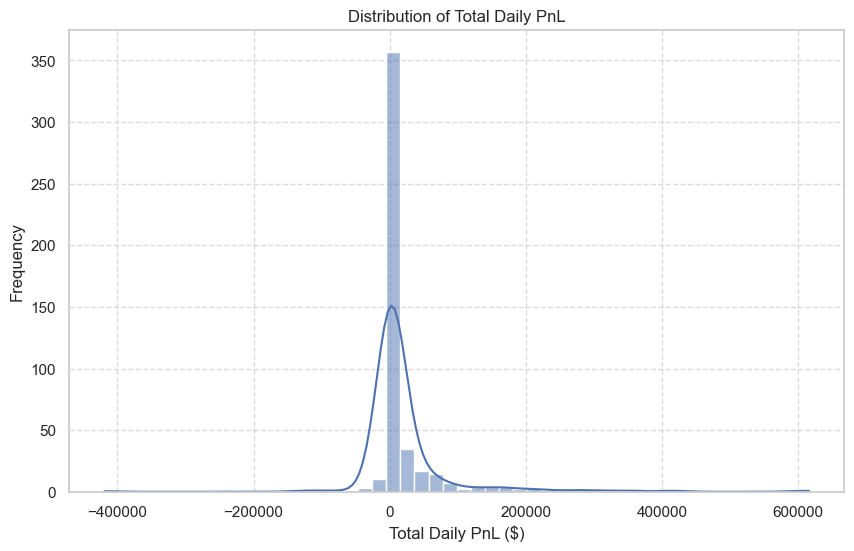


--- Correlation Matrix ---
                                sentiment_score     value  Total_Daily_PnL  \
sentiment_score                        1.000000  0.959435        -0.096127   
value                                  0.959435  1.000000        -0.082642   
Total_Daily_PnL                       -0.096127 -0.082642         1.000000   
Average_Daily_Win_Rate                 0.155556  0.155787         0.149563   
Total_Daily_Trade_Count               -0.246619 -0.245260         0.360523   
Overall_Average_Trade_Size_USD        -0.060457 -0.044105         0.017694   

                                Average_Daily_Win_Rate  \
sentiment_score                               0.155556   
value                                         0.155787   
Total_Daily_PnL                               0.149563   
Average_Daily_Win_Rate                        1.000000   
Total_Daily_Trade_Count                       0.086884   
Overall_Average_Trade_Size_USD               -0.017361   

                  

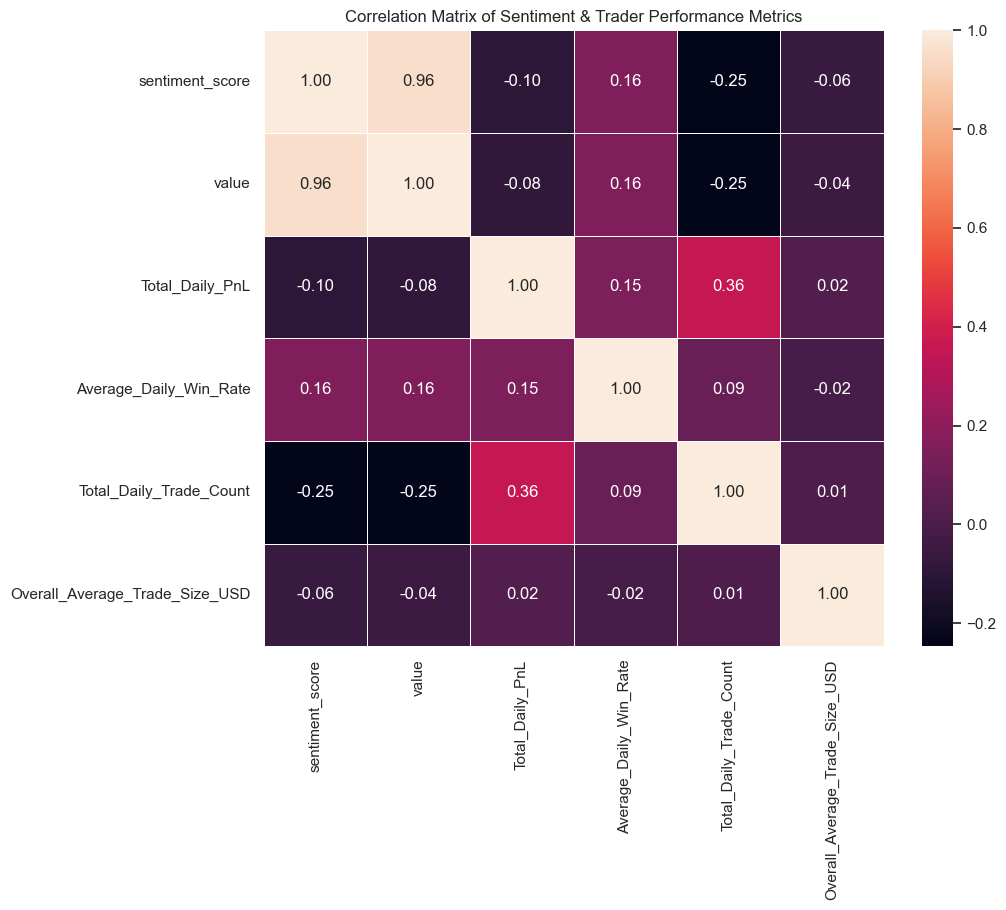

In [7]:
# Descriptive Statistics & EDA

print("\n--- Descriptive Statistics for Sentiment Columns ---")
print(merged_df[['value', 'sentiment_score']].describe())

print("\n--- Descriptive Statistics for Trader Performance Metrics ---")
print(
    merged_df[
        ['Total_Daily_PnL',
         'Average_Daily_Win_Rate',
         'Total_Daily_Trade_Count',
         'Overall_Average_Trade_Size_USD']
    ].describe()
)

# Distribution of Total Daily PnL
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Total_Daily_PnL'], kde=True, bins=50)
plt.title('Distribution of Total Daily PnL')
plt.xlabel('Total Daily PnL ($)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Correlation matrix
sentiment_performance_correlation = merged_df[
    ['sentiment_score',
     'value',
     'Total_Daily_PnL',
     'Average_Daily_Win_Rate',
     'Total_Daily_Trade_Count',
     'Overall_Average_Trade_Size_USD']
].corr(method='pearson')

print("\n--- Correlation Matrix ---")
print(sentiment_performance_correlation)

plt.figure(figsize=(10, 8))
sns.heatmap(
    sentiment_performance_correlation,
    annot=True,
    fmt=".2f",
    linewidths=.5
)
plt.title('Correlation Matrix of Sentiment & Trader Performance Metrics')
plt.show()

In [8]:
#Define Binary Target (PnL_Outcome)

# 1 = profitable day, 0 = loss day
merged_df['PnL_Outcome'] = (merged_df['Total_Daily_PnL'] > 0).astype(int)

print("\n--- Merged DataFrame with PnL_Outcome Head ---")
print(merged_df[['date', 'Total_Daily_PnL', 'PnL_Outcome']].head())

print("\n--- PnL_Outcome value counts ---")
print(merged_df['PnL_Outcome'].value_counts())
print(merged_df['PnL_Outcome'].value_counts(normalize=True))


--- Merged DataFrame with PnL_Outcome Head ---
        date  Total_Daily_PnL  PnL_Outcome
0 2023-05-01         0.000000            0
1 2023-12-05         0.000000            0
2 2023-12-14      -205.434737            0
3 2023-12-15       -24.632034            0
4 2023-12-16         0.000000            0

--- PnL_Outcome value counts ---
PnL_Outcome
1    361
0    118
Name: count, dtype: int64
PnL_Outcome
1    0.753653
0    0.246347
Name: proportion, dtype: float64


In [9]:
#  Initial Feature Set & VIF (Multicollinearity)

X_initial = merged_df[
    ['sentiment_score',
     'value',
     'Average_Daily_Win_Rate',
     'Total_Daily_Trade_Count',
     'Overall_Average_Trade_Size_USD']
].copy()

print("\n--- Initial Feature Matrix (X_initial) Head ---")
print(X_initial.head())

# Compute VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X_initial.columns
vif_data['VIF Score'] = [
    variance_inflation_factor(X_initial.values, i)
    for i in range(len(X_initial.columns))
]

vif_data = vif_data.sort_values(by='VIF Score', ascending=False).reset_index(drop=True)

print("\n--- VIF Scores for Features in X_initial ---")
print(vif_data)

# Drop 'value' if highly collinear with sentiment_score
X_new_base = X_initial.drop('value', axis=1)

vif_data_new = pd.DataFrame()
vif_data_new['Feature'] = X_new_base.columns
vif_data_new['VIF Score'] = [
    variance_inflation_factor(X_new_base.values, i)
    for i in range(len(X_new_base.columns))
]

vif_data_new = vif_data_new.sort_values(by='VIF Score', ascending=False).reset_index(drop=True)

print("\n--- VIF Scores for New Feature Set (without 'value') ---")
print(vif_data_new)


--- Initial Feature Matrix (X_initial) Head ---
   sentiment_score  value  Average_Daily_Win_Rate  Total_Daily_Trade_Count  \
0                3     63                0.000000                        3   
1                4     75                0.000000                        9   
2                3     72                0.363636                       11   
3                3     70                0.000000                        2   
4                3     67                0.000000                        3   

   Overall_Average_Trade_Size_USD  
0                      159.000000  
1                     5556.203333  
2                    10291.213636  
3                     5304.975000  
4                     5116.256667  

--- VIF Scores for Features in X_initial ---
                          Feature  VIF Score
0                           value  67.983925
1                 sentiment_score  58.030432
2          Average_Daily_Win_Rate   2.975205
3  Overall_Average_Trade_Size_USD   2.27

In [10]:
# Add Lag Features & Final Feature Set

lag_days = [1, 3, 7]

# Lag features for 'sentiment_score'
for lag in lag_days:
    merged_df[f'sentiment_score_lag_{lag}d'] = merged_df['sentiment_score'].shift(lag)

# Lag features for 'Total_Daily_PnL'
for lag in lag_days:
    merged_df[f'Total_Daily_PnL_lag_{lag}d'] = merged_df['Total_Daily_PnL'].shift(lag)

# Drop rows with NaNs introduced by lagging
initial_rows_with_lags = merged_df.shape[0]
merged_df.dropna(inplace=True)
if merged_df.shape[0] < initial_rows_with_lags:
    print(f"\nDropped {initial_rows_with_lags - merged_df.shape[0]} rows due to NaN values from lagging.")

# Final feature columns
X_new_columns = [
    'sentiment_score',
    'Average_Daily_Win_Rate',
    'Total_Daily_Trade_Count',
    'Overall_Average_Trade_Size_USD'
]
X_new_columns.extend([f'sentiment_score_lag_{lag}d' for lag in lag_days])
X_new_columns.extend([f'Total_Daily_PnL_lag_{lag}d' for lag in lag_days])

X_new = merged_df[X_new_columns].copy()
y = merged_df['PnL_Outcome']

print("\n--- Updated Merged DataFrame Head (with lag features) ---")
print(merged_df.head())

print("\n--- Updated X_new Head (with lag features) ---")
print(X_new.head())

print("\n--- Updated X_new Columns ---")
print(X_new.columns)


Dropped 7 rows due to NaN values from lagging.

--- Updated Merged DataFrame Head (with lag features) ---
     timestamp  value classification       date  sentiment_score trade_date  \
7   1702963800     73          Greed 2023-12-19                3 2023-12-19   
8   1703050200     74          Greed 2023-12-20                3 2023-12-20   
9   1703136600     70          Greed 2023-12-21                3 2023-12-21   
10  1703223000     74          Greed 2023-12-22                3 2023-12-22   
11  1703309400     70          Greed 2023-12-23                3 2023-12-23   

    Total_Daily_PnL  Average_Daily_Win_Rate  Total_Daily_Trade_Count  \
7       1000.538612                0.666667                       15   
8        162.732282                0.444444                       18   
9        537.211402                0.530612                       49   
10       141.832675                0.200000                       10   
11       146.936704                0.615385               

In [11]:
# Train/Test Split

test_size = 0.2
split_index = int(len(merged_df) * (1 - test_size))

X_train_final = X_new.iloc[:split_index]
X_test_final  = X_new.iloc[split_index:]
y_train_final = y.iloc[:split_index]
y_test_final  = y.iloc[split_index:]

print("\n--- X_train_final Head (Time-Aware Split) ---")
print(X_train_final.head())
print("\n--- y_train_final Head (Time-Aware Split) ---")
print(y_train_final.head())
print("\n--- X_test_final Head (Time-Aware Split) ---")
print(X_test_final.head())
print("\n--- y_test_final Head (Time-Aware Split) ---")
print(y_test_final.head())

print(f"\nTraining set shape (final features, time-aware): {X_train_final.shape}")
print(f"Testing set shape (final features, time-aware): {X_test_final.shape}")
print(f"Target distribution in training set:\n{y_train_final.value_counts(normalize=True)}")
print(f"Target distribution in testing set:\n{y_test_final.value_counts(normalize=True)}")


--- X_train_final Head (Time-Aware Split) ---
    sentiment_score  Average_Daily_Win_Rate  Total_Daily_Trade_Count  \
7                 3                0.666667                       15   
8                 3                0.444444                       18   
9                 3                0.530612                       49   
10                3                0.200000                       10   
11                3                0.615385                       13   

    Overall_Average_Trade_Size_USD  sentiment_score_lag_1d  \
7                      6106.827333                     3.0   
8                      7868.710556                     3.0   
9                      2555.795306                     3.0   
10                     8887.428000                     3.0   
11                     6033.711538                     3.0   

    sentiment_score_lag_3d  sentiment_score_lag_7d  Total_Daily_PnL_lag_1d  \
7                      3.0                     3.0                0.0

In [12]:
#Scale Features (StandardScaler)

print("\n--- Applying StandardScaler to numerical features ---")

scaler = StandardScaler()

# Fit on training data only, then transform both train & test
scaler.fit(X_train_final)

X_train_scaled_final = pd.DataFrame(
    scaler.transform(X_train_final),
    columns=X_train_final.columns,
    index=X_train_final.index
)

X_test_scaled_final = pd.DataFrame(
    scaler.transform(X_test_final),
    columns=X_test_final.columns,
    index=X_test_final.index
)

print("\n--- X_train_scaled_final Head ---")
print(X_train_scaled_final.head())

print("\n--- X_test_scaled_final Head ---")
print(X_test_scaled_final.head())


--- Applying StandardScaler to numerical features ---

--- X_train_scaled_final Head ---
    sentiment_score  Average_Daily_Win_Rate  Total_Daily_Trade_Count  \
7          0.093744                1.313820                -0.432805   
8          0.093744                0.461157                -0.424992   
9          0.093744                0.791781                -0.344250   
10         0.093744               -0.476772                -0.445828   
11         0.093744                1.117052                -0.438014   

    Overall_Average_Trade_Size_USD  sentiment_score_lag_1d  \
7                        -0.107235                0.093744   
8                         0.225297                0.093744   
9                        -0.777445                0.093744   
10                        0.417566                0.093744   
11                       -0.121035                0.093744   

    sentiment_score_lag_3d  sentiment_score_lag_7d  Total_Daily_PnL_lag_1d  \
7                 0.099421

In [13]:
#fixing class imbalances with smote
print("\n--- Applying SMOTE to training data (scaled final features) ---")

smote = SMOTE(random_state=42)
X_resampled_final, y_resampled_final = smote.fit_resample(X_train_scaled_final, y_train_final)

print("\n--- Class Balance in y_resampled_final after SMOTE ---")
print(y_resampled_final.value_counts())
print(y_resampled_final.value_counts(normalize=True))


--- Applying SMOTE to training data (scaled final features) ---

--- Class Balance in y_resampled_final after SMOTE ---
PnL_Outcome
1    275
0    275
Name: count, dtype: int64
PnL_Outcome
1    0.5
0    0.5
Name: proportion, dtype: float64



--- Training Baseline Logistic Regression Model ---

--- Logistic Regression Classification Report ---
              precision    recall  f1-score   support

           0       0.22      0.70      0.33        10
           1       0.95      0.71      0.81        85

    accuracy                           0.71        95
   macro avg       0.59      0.70      0.57        95
weighted avg       0.88      0.71      0.76        95

ROC AUC Score (Logistic Regression): 0.7012


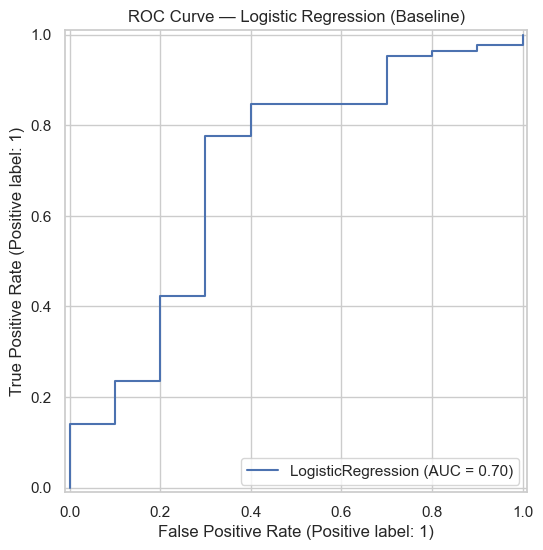


--- Logistic Regression Coefficients (Sorted by |Coefficient|) ---
                          Feature  Coefficient  Absolute_Coefficient
1          Average_Daily_Win_Rate     4.120176              4.120176
2         Total_Daily_Trade_Count    -0.884186              0.884186
5          sentiment_score_lag_3d    -0.603041              0.603041
3  Overall_Average_Trade_Size_USD    -0.602874              0.602874
0                 sentiment_score     0.422411              0.422411
9          Total_Daily_PnL_lag_7d     0.370210              0.370210
4          sentiment_score_lag_1d     0.357445              0.357445
6          sentiment_score_lag_7d    -0.236322              0.236322
8          Total_Daily_PnL_lag_3d     0.229915              0.229915
7          Total_Daily_PnL_lag_1d     0.036386              0.036386


In [14]:
# logistic regression
print("\n--- Training Baseline Logistic Regression Model ---")

lr_baseline = LogisticRegression(
    random_state=42,
    solver='liblinear',
    max_iter=1000
)

lr_baseline.fit(X_resampled_final, y_resampled_final)

y_pred_lr = lr_baseline.predict(X_test_scaled_final)
y_pred_proba_lr = lr_baseline.predict_proba(X_test_scaled_final)[:, 1]

print("\n--- Logistic Regression Classification Report ---")
print(classification_report(y_test_final, y_pred_lr))

roc_auc_lr = roc_auc_score(y_test_final, y_pred_proba_lr)
print(f"ROC AUC Score (Logistic Regression): {roc_auc_lr:.4f}")

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(lr_baseline, X_test_scaled_final, y_test_final, ax=plt.gca())
plt.title('ROC Curve — Logistic Regression (Baseline)')
plt.grid(True)
plt.show()

# Coefficients as feature importance
coefficients = pd.DataFrame({
    'Feature': X_resampled_final.columns,
    'Coefficient': lr_baseline.coef_[0]
})
coefficients['Absolute_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Absolute_Coefficient', ascending=False)

print("\n--- Logistic Regression Coefficients (Sorted by |Coefficient|) ---")
print(coefficients)


--- Training Baseline Random Forest Model ---

--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.89      0.92      0.90        85

    accuracy                           0.82        95
   macro avg       0.44      0.46      0.45        95
weighted avg       0.79      0.82      0.81        95

ROC AUC Score (Random Forest): 0.4400


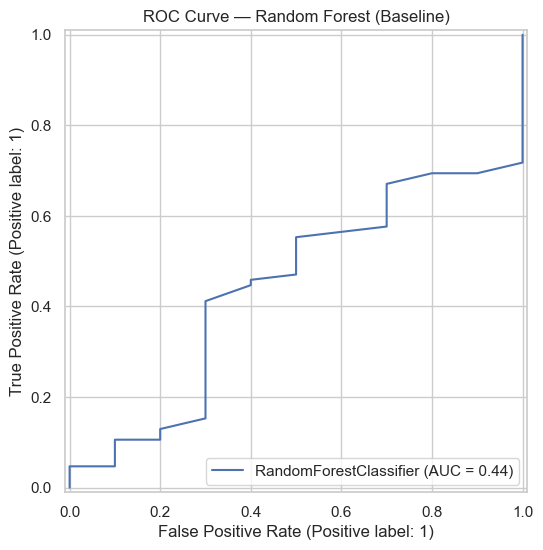


--- Random Forest Feature Importances (Baseline) ---
                          Feature  Importance
1          Average_Daily_Win_Rate    0.526059
2         Total_Daily_Trade_Count    0.107345
3  Overall_Average_Trade_Size_USD    0.071446
7          Total_Daily_PnL_lag_1d    0.067882
8          Total_Daily_PnL_lag_3d    0.057639
9          Total_Daily_PnL_lag_7d    0.047533
0                 sentiment_score    0.041068
4          sentiment_score_lag_1d    0.031763
6          sentiment_score_lag_7d    0.025725
5          sentiment_score_lag_3d    0.023538


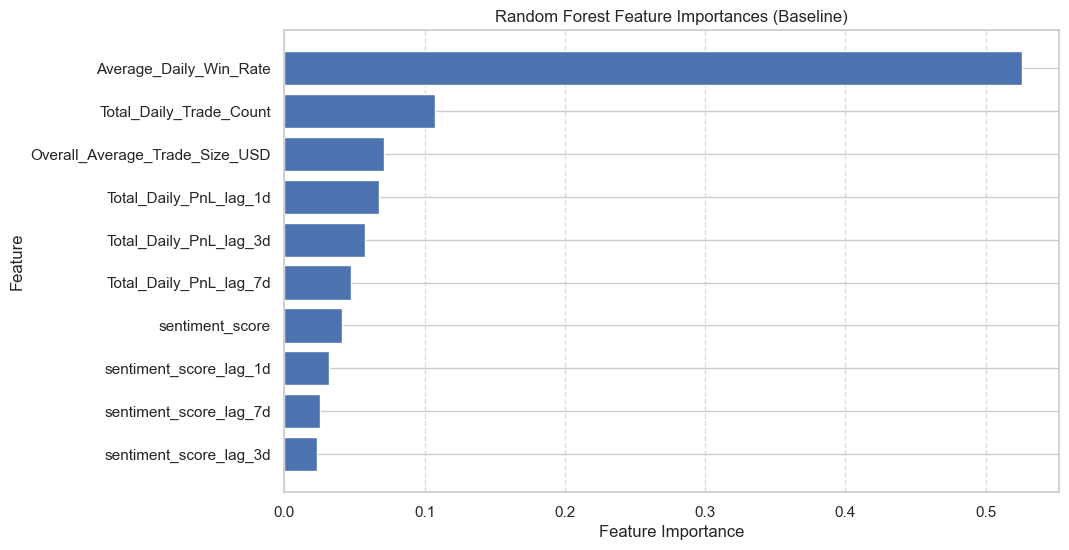

In [15]:
# random forest
print("\n--- Training Baseline Random Forest Model ---")

rf_baseline = RandomForestClassifier(
    random_state=42,
    n_estimators=200
)

rf_baseline.fit(X_resampled_final, y_resampled_final)

y_pred_rf = rf_baseline.predict(X_test_scaled_final)
y_pred_proba_rf = rf_baseline.predict_proba(X_test_scaled_final)[:, 1]

print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test_final, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test_final, y_pred_proba_rf)
print(f"ROC AUC Score (Random Forest): {roc_auc_rf:.4f}")

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(rf_baseline, X_test_scaled_final, y_test_final, ax=plt.gca())
plt.title('ROC Curve — Random Forest (Baseline)')
plt.grid(True)
plt.show()

# Feature importances
rf_importances = pd.DataFrame({
    'Feature': X_resampled_final.columns,
    'Importance': rf_baseline.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- Random Forest Feature Importances (Baseline) ---")
print(rf_importances)

plt.figure(figsize=(10, 6))
plt.barh(rf_importances['Feature'], rf_importances['Importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances (Baseline)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [16]:
#  Helper Function: calculate_metrics

print("\n--- Defining calculate_metrics function ---")

def calculate_metrics(X_train_resampled, y_train_resampled, X_test, y_test):
    # Logistic Regression
    lr_model = LogisticRegression(
        random_state=42,
        solver='liblinear',
        max_iter=1000
    )
    lr_model.fit(X_train_resampled, y_train_resampled)
    y_pred_lr = lr_model.predict(X_test)
    y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    f1_0_lr = f1_score(y_test, y_pred_lr, pos_label=0)
    f1_1_lr = f1_score(y_test, y_pred_lr, pos_label=1)
    roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

    # Random Forest
    rf_model = RandomForestClassifier(
        random_state=42,
        n_estimators=200
    )
    rf_model.fit(X_train_resampled, y_train_resampled)
    y_pred_rf = rf_model.predict(X_test)
    y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    f1_0_rf = f1_score(y_test, y_pred_rf, pos_label=0)
    f1_1_rf = f1_score(y_test, y_pred_rf, pos_label=1)
    roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

    return {
        'lr': {
            'accuracy': accuracy_lr,
            'f1_0': f1_0_lr,
            'f1_1': f1_1_lr,
            'roc_auc': roc_auc_lr
        },
        'rf': {
            'accuracy': accuracy_rf,
            'f1_0': f1_0_rf,
            'f1_1': f1_1_rf,
            'roc_auc': roc_auc_rf
        }
    }

print("Function 'calculate_metrics' defined successfully.")


--- Defining calculate_metrics function ---
Function 'calculate_metrics' defined successfully.


In [17]:
#  Bootstrap Evaluation (Confidence Intervals)

metrics_list = ['accuracy', 'f1_0', 'f1_1', 'roc_auc']

print("\n--- Metrics for Confidence Interval Calculation ---")
print(metrics_list)

n_iterations = 1000  # Number of bootstrap samples

lr_metrics_bootstrap = {metric: [] for metric in metrics_list}
rf_metrics_bootstrap = {metric: [] for metric in metrics_list}

print(f"\n--- Performing {n_iterations} bootstrap iterations ---")

for i in range(n_iterations):
    # Resample the balanced training data
    X_sample, y_sample = resample(
        X_resampled_final,
        y_resampled_final,
        replace=True,
        stratify=y_resampled_final,
        random_state=i
    )

    # Calculate metrics for this bootstrap sample
    metrics = calculate_metrics(X_sample, y_sample, X_test_scaled_final, y_test_final)

    # Store LR metrics
    for metric_name in metrics_list:
        lr_metrics_bootstrap[metric_name].append(metrics['lr'][metric_name])

    # Store RF metrics
    for metric_name in metrics_list:
        rf_metrics_bootstrap[metric_name].append(metrics['rf'][metric_name])

print("\nBootstrapping complete. Stored metrics for both models.")


--- Metrics for Confidence Interval Calculation ---
['accuracy', 'f1_0', 'f1_1', 'roc_auc']

--- Performing 1000 bootstrap iterations ---

Bootstrapping complete. Stored metrics for both models.


In [18]:
#  95% Confidence Intervals

alpha = 0.95
lower_percentile = (1 - alpha) / 2 * 100
upper_percentile = (1 + alpha) / 2 * 100

print(f"\n--- {int(alpha*100)}% Confidence Intervals for Logistic Regression ---")
for metric_name in metrics_list:
    lower = np.percentile(lr_metrics_bootstrap[metric_name], lower_percentile)
    upper = np.percentile(lr_metrics_bootstrap[metric_name], upper_percentile)
    print(f"{metric_name.replace('_', ' ').capitalize()}: ({lower:.4f}, {upper:.4f})")

print(f"\n--- {int(alpha*100)}% Confidence Intervals for Random Forest ---")
for metric_name in metrics_list:
    lower = np.percentile(rf_metrics_bootstrap[metric_name], lower_percentile)
    upper = np.percentile(rf_metrics_bootstrap[metric_name], upper_percentile)
    print(f"{metric_name.replace('_', ' ').capitalize()}: ({lower:.4f}, {upper:.4f})")


--- 95% Confidence Intervals for Logistic Regression ---
Accuracy: (0.4947, 0.8000)
F1 0: (0.2258, 0.4000)
F1 1: (0.6250, 0.8820)
Roc auc: (0.6211, 0.7576)

--- 95% Confidence Intervals for Random Forest ---
Accuracy: (0.6000, 0.8947)
F1 0: (0.0000, 0.1818)
F1 1: (0.7412, 0.9444)
Roc auc: (0.3770, 0.6247)



--- Starting Hyperparameter Tuning for Logistic Regression ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

--- Hyperparameter Tuning Results for Logistic Regression ---
Best Hyperparameters: {'C': 100, 'penalty': 'l2'}
Best F1-Score (CV): 0.8090

--- Tuned Logistic Regression Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.70      0.33        10
           1       0.95      0.69      0.80        85

    accuracy                           0.69        95
   macro avg       0.58      0.70      0.56        95
weighted avg       0.87      0.69      0.75        95

ROC AUC Score (Tuned Logistic Regression): 0.6906


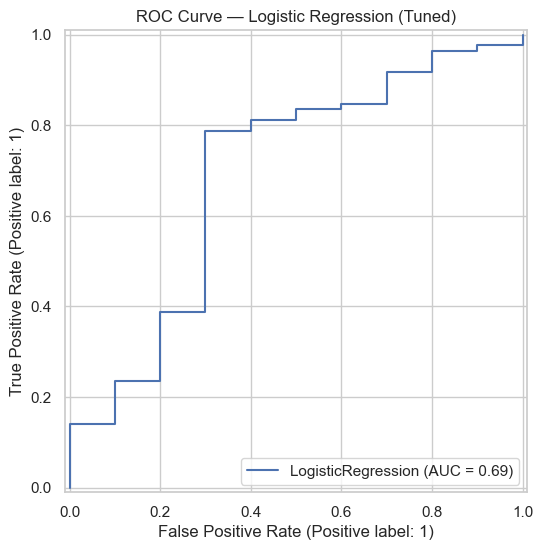

In [19]:
#  Hyperparameter Tuning: Logistic Regression

print("\n--- Starting Hyperparameter Tuning for Logistic Regression ---")

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

lr_base_model = LogisticRegression(
    random_state=42,
    solver='liblinear',
    max_iter=1000
)

grid_search_lr = GridSearchCV(
    estimator=lr_base_model,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_resampled_final, y_resampled_final)

print("\n--- Hyperparameter Tuning Results for Logistic Regression ---")
print(f"Best Hyperparameters: {grid_search_lr.best_params_}")
print(f"Best F1-Score (CV): {grid_search_lr.best_score_:.4f}")

best_lr_model = grid_search_lr.best_estimator_

# Evaluate tuned LR on test data
y_pred_lr_tuned = best_lr_model.predict(X_test_scaled_final)
y_pred_proba_lr_tuned = best_lr_model.predict_proba(X_test_scaled_final)[:, 1]

print("\n--- Tuned Logistic Regression Model Evaluation ---")
print("Classification Report:")
print(classification_report(y_test_final, y_pred_lr_tuned))

roc_auc_lr_tuned = roc_auc_score(y_test_final, y_pred_proba_lr_tuned)
print(f"ROC AUC Score (Tuned Logistic Regression): {roc_auc_lr_tuned:.4f}")

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_lr_model, X_test_scaled_final, y_test_final, ax=plt.gca())
plt.title('ROC Curve — Logistic Regression (Tuned)')
plt.grid(True)
plt.show()


--- Starting Hyperparameter Tuning for Random Forest ---
Fitting 5 folds for each of 162 candidates, totalling 810 fits

--- Hyperparameter Tuning Results for Random Forest ---
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best F1-Score (CV): 0.8506

--- Tuned Random Forest Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.89      0.94      0.91        85

    accuracy                           0.84        95
   macro avg       0.44      0.47      0.46        95
weighted avg       0.80      0.84      0.82        95

ROC AUC Score (Tuned Random Forest): 0.4718


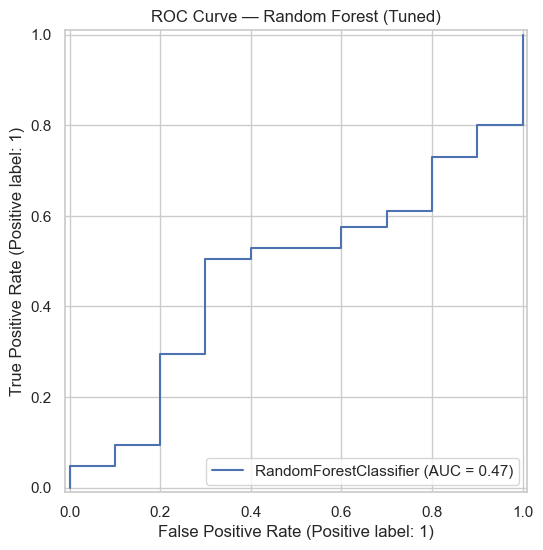


--- Random Forest Feature Importances (Tuned) ---
                          Feature  Importance
1          Average_Daily_Win_Rate    0.541516
2         Total_Daily_Trade_Count    0.103475
3  Overall_Average_Trade_Size_USD    0.072892
7          Total_Daily_PnL_lag_1d    0.063687
8          Total_Daily_PnL_lag_3d    0.055291
9          Total_Daily_PnL_lag_7d    0.045785
0                 sentiment_score    0.039694
4          sentiment_score_lag_1d    0.029052
6          sentiment_score_lag_7d    0.025427
5          sentiment_score_lag_3d    0.023179


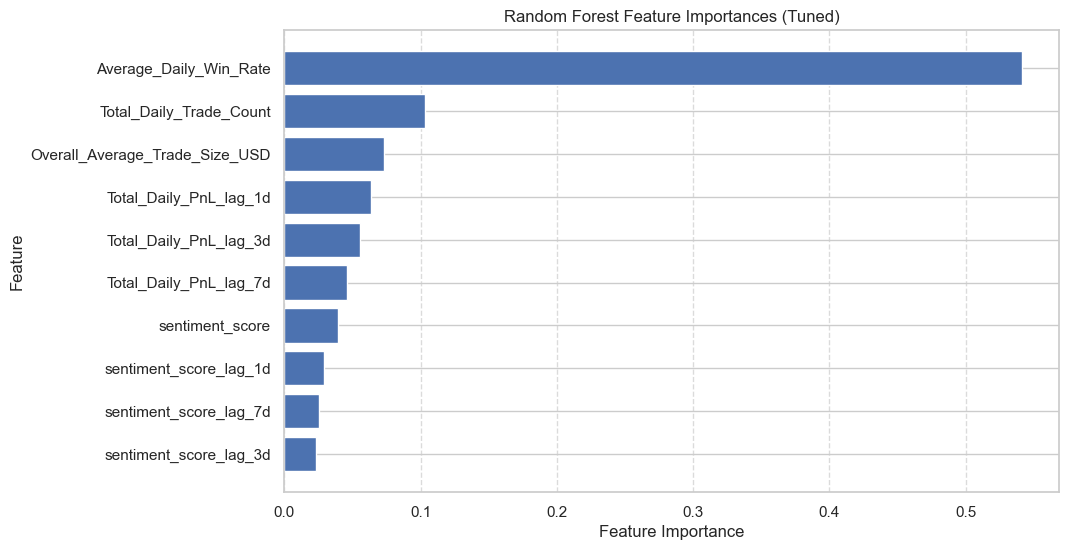

In [20]:
#  Hyperparameter Tuning: Random Forest

print("\n--- Starting Hyperparameter Tuning for Random Forest ---")

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_base_model = RandomForestClassifier(
    random_state=42
)

grid_search_rf = GridSearchCV(
    estimator=rf_base_model,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_resampled_final, y_resampled_final)

print("\n--- Hyperparameter Tuning Results for Random Forest ---")
print(f"Best Hyperparameters: {grid_search_rf.best_params_}")
print(f"Best F1-Score (CV): {grid_search_rf.best_score_:.4f}")

best_rf_model = grid_search_rf.best_estimator_

# Evaluate tuned RF on test data
y_pred_rf_tuned = best_rf_model.predict(X_test_scaled_final)
y_pred_proba_rf_tuned = best_rf_model.predict_proba(X_test_scaled_final)[:, 1]

print("\n--- Tuned Random Forest Model Evaluation ---")
print("Classification Report:")
print(classification_report(y_test_final, y_pred_rf_tuned))

roc_auc_rf_tuned = roc_auc_score(y_test_final, y_pred_proba_rf_tuned)
print(f"ROC AUC Score (Tuned Random Forest): {roc_auc_rf_tuned:.4f}")

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_rf_model, X_test_scaled_final, y_test_final, ax=plt.gca())
plt.title('ROC Curve — Random Forest (Tuned)')
plt.grid(True)
plt.show()

# Tuned RF feature importance
rf_importances_tuned = pd.DataFrame({
    'Feature': X_resampled_final.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- Random Forest Feature Importances (Tuned) ---")
print(rf_importances_tuned)

plt.figure(figsize=(10, 6))
plt.barh(rf_importances_tuned['Feature'], rf_importances_tuned['Importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances (Tuned)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [21]:
# TimeSeriesSplit Cross-Validation (on Training)

print("\n--- TimeSeriesSplit Cross-Validation on Training Data ---")

tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled_final)):
    X_tr, X_val = X_train_scaled_final.iloc[train_idx], X_train_scaled_final.iloc[val_idx]
    y_tr, y_val = y_train_final.iloc[train_idx], y_train_final.iloc[val_idx]

    # Use RF as example
    rf_cv = RandomForestClassifier(random_state=42, n_estimators=200)
    rf_cv.fit(X_tr, y_tr)
    y_val_pred = rf_cv.predict(X_val)
    y_val_proba = rf_cv.predict_proba(X_val)[:, 1]
    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_proba)

    print(f"Fold {fold+1} — Accuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")


--- TimeSeriesSplit Cross-Validation on Training Data ---
Fold 1 — Accuracy: 0.9516, F1: 0.9691, AUC: 0.9122
Fold 2 — Accuracy: 0.9194, F1: 0.9451, AUC: 1.0000
Fold 3 — Accuracy: 0.9032, F1: 0.9143, AUC: 0.9692
Fold 4 — Accuracy: 0.9677, F1: 0.9778, AUC: 0.9306
Fold 5 — Accuracy: 0.8871, F1: 0.9402, AUC: 0.4260


In [22]:
# : XGBoost, LightGBM, CatBoost

print("\n--- Training Gradient Boosting Models (XGBoost, LightGBM, CatBoost) ---")

xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9
)

lgbm_model = LGBMClassifier(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05
)

cat_model = CatBoostClassifier(
    random_state=42,
    verbose=0,
    iterations=300,
    learning_rate=0.05
)

xgb_model.fit(X_resampled_final, y_resampled_final)
lgbm_model.fit(X_resampled_final, y_resampled_final)
cat_model.fit(X_resampled_final, y_resampled_final)

models = {
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model,
    'CatBoost': cat_model
}

for name, mdl in models.items():
    y_pred = mdl.predict(X_test_scaled_final)
    y_pred_proba = mdl.predict_proba(X_test_scaled_final)[:, 1]
    print(f"\n--- {name} Performance ---")
    print(classification_report(y_test_final, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test_final, y_pred_proba):.4f}")


--- Training Gradient Boosting Models (XGBoost, LightGBM, CatBoost) ---
[LightGBM] [Info] Number of positive: 275, number of negative: 275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1118
[LightGBM] [Info] Number of data points in the train set: 550, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

C:\Users\HP\AppData\Local\Temp\ipykernel_6520\579362404.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_matrix, X_test_scaled_final, feature_names=X_test_scaled_final.columns)
D:\anoconda\Lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
D:\anoconda\Lib\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


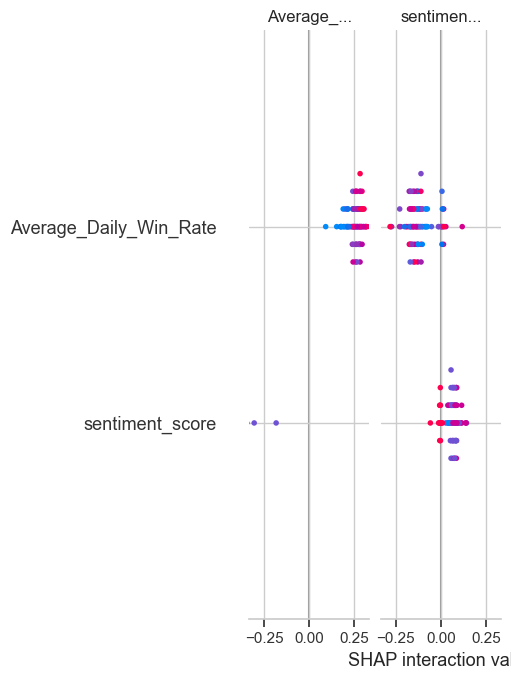

In [25]:
import shap
shap.initjs()

explainer_rf = shap.TreeExplainer(best_rf_model, model_output="raw")
shap_values_rf = explainer_rf(X_test_scaled_final)

# shap_values_rf.values has shape (n_samples, n_features_plus_base)
shap_values_matrix = shap_values_rf.values

# Remove extra column if exists
if shap_values_matrix.shape[1] != X_test_scaled_final.shape[1]:
    shap_values_matrix = shap_values_matrix[:, :X_test_scaled_final.shape[1]]

# Summary plot
shap.summary_plot(shap_values_matrix, X_test_scaled_final, feature_names=X_test_scaled_final.columns)



--- Prophet Forecasting on Total Daily PnL ---


01:01:49 - cmdstanpy - INFO - Chain [1] start processing
01:01:50 - cmdstanpy - INFO - Chain [1] done processing


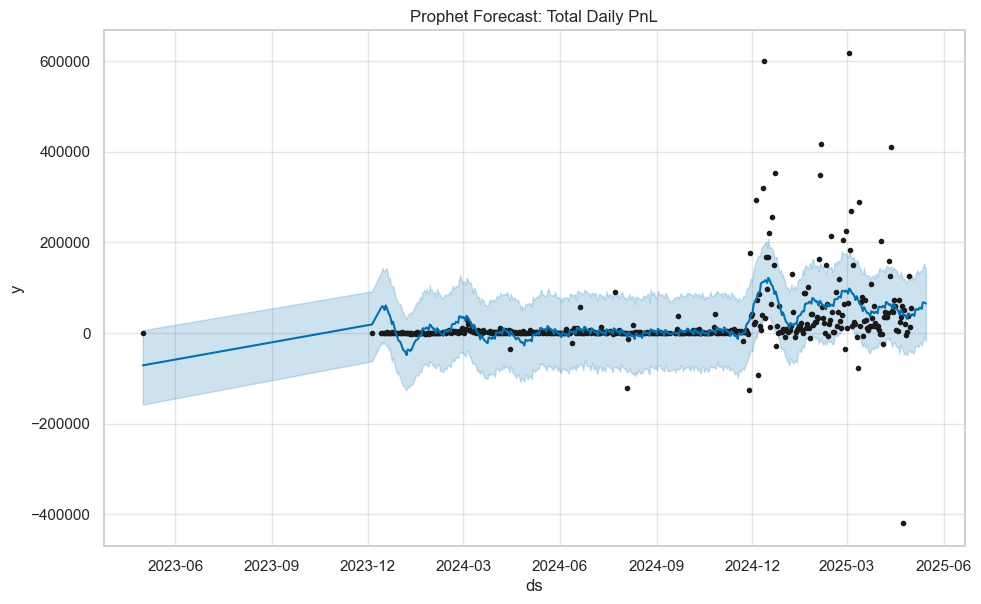

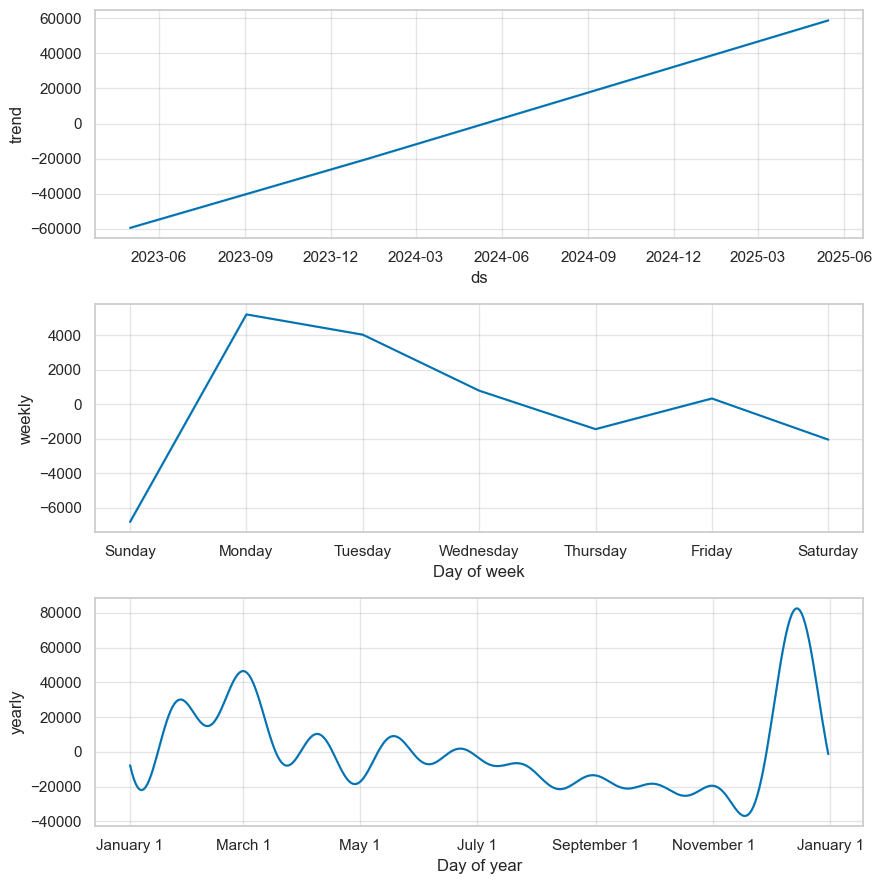

In [26]:
# trying timeseries model prophet
print("\n--- Prophet Forecasting on Total Daily PnL ---")

# Use aggregated_daily_trader_df for pure PnL time series
df_prophet = aggregated_daily_trader_df[['trade_date', 'Total_Daily_PnL']].rename(
    columns={'trade_date': 'ds', 'Total_Daily_PnL': 'y'}
)

prophet_model = Prophet()
prophet_model.fit(df_prophet)

future = prophet_model.make_future_dataframe(periods=14)
forecast = prophet_model.predict(future)

fig1 = prophet_model.plot(forecast)
plt.title("Prophet Forecast: Total Daily PnL")
plt.show()

fig2 = prophet_model.plot_components(forecast)
plt.show()


--- ARIMA Benchmark on Total Daily PnL ---


D:\anoconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anoconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anoconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  480
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -5990.397
Date:                Tue, 25 Nov 2025   AIC                          11996.795
Time:                        01:02:25   BIC                          12030.168
Sample:                             0   HQIC                         12009.914
                                - 480                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2219      0.207     -1.072      0.284      -0.627       0.184
ar.L2          0.1485      0.055      2.711      0.007       0.041       0.256
ar.L3          0.0986      0.052      1.893      0.0

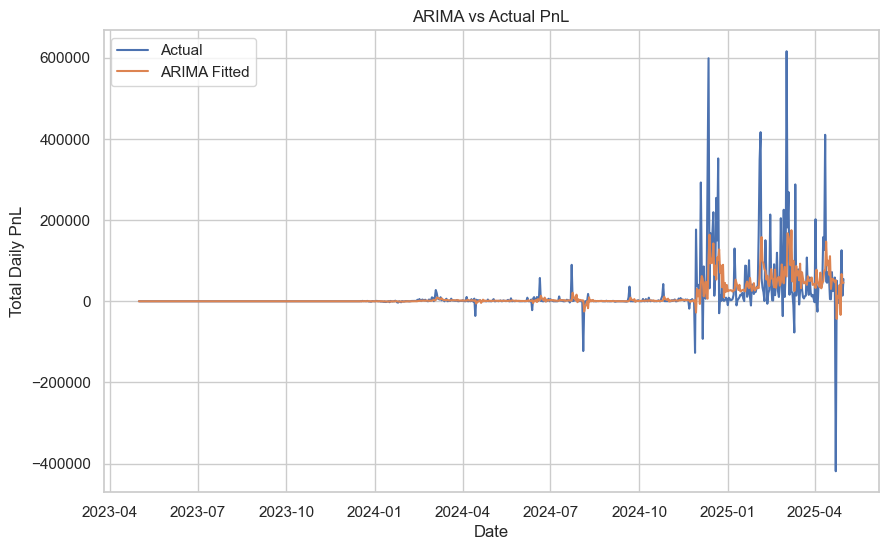

In [27]:
# ARIMA Benchmark on Total Daily PnL

print("\n--- ARIMA Benchmark on Total Daily PnL ---")

df_arima = df_prophet.set_index('ds')['y']

arima_model = ARIMA(df_arima, order=(5, 1, 2))
arima_fit = arima_model.fit()

print(arima_fit.summary())

plt.figure(figsize=(10, 6))
plt.plot(df_arima, label="Actual")
plt.plot(arima_fit.fittedvalues, label="ARIMA Fitted")
plt.legend()
plt.title("ARIMA vs Actual PnL")
plt.xlabel("Date")
plt.ylabel("Total Daily PnL")
plt.grid(True)
plt.show()

In [28]:
# Rolling-Window Retraining (Walk-Forward)

print("\n--- Rolling-Window Retraining (Walk-Forward Evaluation) ---")

# Use X_new (features with lags) and y, already ordered by date
window_size = 60  # number of days in training window
predictions_rw = []
actuals_rw = []

for i in range(window_size, len(X_new)):
    X_train_rw = X_new.iloc[i-window_size:i]
    y_train_rw = y.iloc[i-window_size:i]
    X_test_rw = X_new.iloc[i:i+1]
    y_test_rw = y.iloc[i:i+1]

    model_rw = RandomForestClassifier(random_state=42, n_estimators=200)
    model_rw.fit(X_train_rw, y_train_rw)

    pred = model_rw.predict(X_test_rw)[0]
    predictions_rw.append(pred)
    actuals_rw.append(y_test_rw.values[0])

rolling_accuracy = accuracy_score(actuals_rw, predictions_rw)
rolling_f1 = f1_score(actuals_rw, predictions_rw)

print(f"Rolling Window Accuracy: {rolling_accuracy:.4f}")
print(f"Rolling Window F1 Score: {rolling_f1:.4f}")


--- Rolling-Window Retraining (Walk-Forward Evaluation) ---
Rolling Window Accuracy: 0.9345
Rolling Window F1 Score: 0.9596
